In [126]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [127]:
import pandas as pd
import numpy as np
# 데이터 불러오기
contents = pd.read_csv('/gdrive/Shared drives/datathon_2021/contents.csv',encoding='cp949')
ratings = pd.read_csv('/gdrive/Shared drives/datathon_2021/ratings.csv',encoding='cp949')

In [128]:
# surprise 패키지 설치
!pip install surprise

In [129]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5)) # 선호도는 1점~5점
data = Dataset.load_from_df(ratings[['userid','club','ratings']], reader=reader)
full_train = data.build_full_trainset() # 전체 추천 결과에 전체 데이터셋 사용

## EDA
# 평균 평점

In [130]:
result1 = ratings.groupby(['club'], as_index=False).mean()
print(result1.shape[0]) # 전체 동아리 수
print(round(result1['ratings'].mean(),3)) # 평균 평점

82
3.325


Text(0.5, 1.0, 'Mean Ratings of clubs')

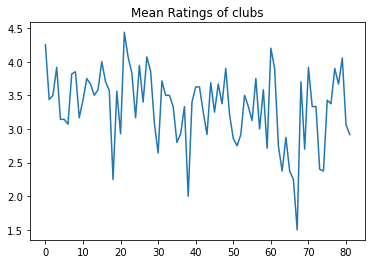

In [131]:
import matplotlib.pyplot as plt
plt.plot(range(82),result1['ratings'])
plt.title('Mean Ratings of clubs')

## Long-tail plot

In [132]:
result2 = ratings.groupby(['club'], as_index=False).count()
result2 = result2.iloc[:,:2]
result2 = result2.sort_values(by='userid',ascending=False)
round(result2['userid'].describe(),3) # 동아리별 평점 수 정보

count    82.000
mean      6.500
std       1.657
min       4.000
25%       5.250
50%       6.000
75%       7.750
max      12.000
Name: userid, dtype: float64

Text(0.5, 0, 'items')

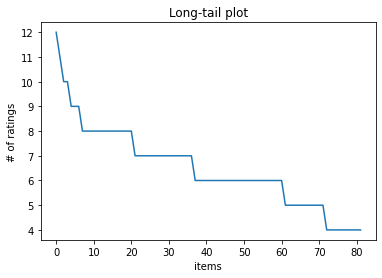

In [133]:
plt.plot(range(82),result2['userid'])
plt.title('Long-tail plot')
plt.ylabel('# of ratings')
plt.xlabel('items')

## item-based

In [134]:
item_user_ratings = ratings.pivot_table('ratings',index='club',columns='userid') # 데이터 형태 변경
item_user_ratings.fillna(0, inplace=True)
item_user_ratings

userid,Imchaechae,abgc4531,agalg,aio812,americano,avuc12131,bionda7,catlover6487,chae1999,chaechae,chaeisthebest,csv654,dae5686,dongari,dpow3146,gdrt567,gglp11,gohome11,google11,ha23,haeddeora,haha679,hello994,hey676,heyboy,him9879,hoihoi33,hook00,ich1992,iqeq99,jeju7987,jeonga11,jupyter113,kakao7168,korea1123,lala11,lgka88,lulu77,luo2165,mulmul,nunu234,ooun771,opt758,pask4687,pd1245,ppu888,python99,qldb44,qlek1,qlwbl77,qoieppl5,row8989,seoul66,starbucks,stranger,tplb52,ulp2164,usa6681,whee12,zip456
club,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,4.0,4.5,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,4.0,4.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,4.5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0
4,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0


In [135]:
from sklearn.metrics.pairwise import cosine_similarity
item_based_collabor = cosine_similarity(item_user_ratings) # 유사도 측정 척도로 cosine similarity를 사용
clubid = item_user_ratings.index
item_based_collabor = pd.DataFrame(data=item_based_collabor, index=clubid, columns=clubid)
item_based_collabor # 동아리간 유사도. 유사할수록 1에 가까움

club,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,21,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,...,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,73,74,75,76,77,78,79,80,81,82,83,84,85,86
club,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.561928,0.324476,0.476841,0.152641,0.151660,0.334723,0.353254,0.107326,0.116720,0.132864,0.000000,0.000000,0.000000,0.207850,0.000000,0.000000,0.000000,0.339304,0.248993,0.255523,0.151391,0.085317,0.198417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.088492,0.445468,0.675525,0.339530,0.000000,0.000000,0.000000,0.155181,0.000000,0.000000,...,0.0,0.210783,0.000000,0.178249,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.112850,0.000000,0.050565,0.000000,0.000000,0.000000,0.071476,0.0,0.0,0.0,0.000000,0.287649,0.105244,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.337413,0.214266,0.000000,0.000000,0.000000,0.104397
2,0.561928,1.000000,0.195133,0.338538,0.172116,0.195439,0.139106,0.678625,0.361135,0.358276,0.355117,0.000000,0.000000,0.000000,0.260409,0.000000,0.000000,0.000000,0.340083,0.374347,0.309465,0.189673,0.000000,0.198872,0.000000,0.000000,0.000000,0.000000,0.072978,0.104466,0.091651,0.317607,0.338538,0.194462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.178659,0.0,0.000000,0.0,0.000000,0.000000,0.033786,0.107253,0.197940,0.000000,0.010136,0.087356,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.035638,0.157207,0.178357,0.000000,0.271225,0.262883,0.000000,0.257022,0.177176,0.344914,0.000000,0.041182,0.000000
3,0.324476,0.195133,1.000000,0.498051,0.298156,0.279781,0.694571,0.283247,0.000000,0.000000,0.179425,0.000000,0.232416,0.000000,0.184202,0.000000,0.000000,0.000000,0.305473,0.054040,0.032350,0.000000,0.075610,0.251202,0.000000,0.201005,0.192709,0.088550,0.322635,0.293234,0.059751,0.293036,0.191171,0.276336,0.054169,0.000000,0.154107,0.137525,0.182717,0.215515,...,0.0,0.000000,0.228143,0.220028,0.0,0.000000,0.0,0.244142,0.044229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063344,0.0,0.0,0.0,0.000000,0.254922,0.053297,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230617,0.000000,0.000000,0.161641,0.209305,0.254892,0.092520
4,0.476841,0.338538,0.498051,1.000000,0.535447,0.505550,0.428254,0.451282,0.201763,0.237520,0.427255,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.327333,0.000000,0.000000,0.000000,0.092595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.358865,0.218329,0.157926,0.000000,0.000000,0.000000,0.168420,0.171319,0.202071,...,0.0,0.200170,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077574,0.0,0.0,0.0,0.000000,0.312188,0.185611,0.0,0.0,0.000000,0.000000,0.170228,0.193129,0.000000,0.000000,0.000000,0.147221,0.205070,0.000000,0.281464,0.274124,0.270346,0.113304
5,0.152641,0.172116,0.298156,0.535447,1.000000,0.993569,0.363047,0.357223,0.271661,0.243304,0.234460,0.048251,0.063778,0.181818,0.000000,0.033285,0.038898,0.161577,0.000000,0.148294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140542,0.000000,0.144955,0.000000,0.000000,0.141552,0.092267,0.171641,0.161165,0.190094,...,0.0,0.219690,0.000000,0.000000,0.0,0.000000,0.0,0.044664,0.000000,0.000000,0.099136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.214158,0.0,0.0,0.090187,0.114353,0.087576,0.079486,0.089121,0.250700,0.242990,0.138495,0.000000,0.000000,0.350496,0.378349,0.348710,0.081606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [136]:
matching = pd.concat([pd.DataFrame(contents['동아리'],index=range(82)),pd.DataFrame(clubid,index=range(82))],axis=1)
matching # 동아리 번호와 동아리 이름 매칭을 위한 DataFrame

,동아리,club
0,JASS,1
1,TTP,2
2,고대농악대,3
3,고전기타부,4
4,고려대학교 관악부,5
...,...,...
77,수호회,82
78,아마추어축구부,83
79,탁구사랑회,84
80,택견한울,85


In [137]:
def get_item_based_collabor(title):
  rec = item_based_collabor[title].sort_values(ascending=False)[1:6]
  cnt = 0
  for i in rec.index:
    name = matching[matching['club'] == i]['동아리']
    if cnt == 0 :
      top_item_titles = name
      cnt += 1
    else :
      top_item_titles = pd.concat([top_item_titles,name])
  return top_item_titles

In [138]:
get_item_based_collabor(1)

32    TERRA
1       TTP
3     고전기타부
31     LoGS
7      그루터기
Name: 동아리, dtype: object

In [139]:
clubname = pd.DataFrame({"clubname":contents['동아리']})

for i in clubid:
  temp = pd.DataFrame(get_item_based_collabor(i)).T
  temp.columns = ['rec_1','rec_2','rec_3','rec_4','rec_5']
  if i == 1:
    item_based_recom = temp
  else :
    item_based_recom = pd.concat([item_based_recom,temp], axis=0)

item_based_recom.index = list(range(82))

item_based_recom = pd.concat([clubname,item_based_recom],axis=1)
item_based_recom

,clubname,rec_1,rec_2,rec_3,rec_4,rec_5
0,JASS,TERRA,TTP,고전기타부,LoGS,그루터기
1,TTP,그루터기,JASS,KUCC,노래얼,크림슨
2,고대농악대,국악연구회,고전기타부,JASS,중국연구회,고고쉼
3,고전기타부,고려대학교 관악부,고려대학교 관현악단,고대농악대,JASS,그루터기
4,고려대학교 관악부,고려대학교 관현악단,고전기타부,탁구사랑회,국악연구회,그루터기
...,...,...,...,...,...,...
77,수호회,백구회,농구연구회,궁도회,택견한울,탁구사랑회
78,아마추어축구부,고풋,궁도회,농구연구회,백구회,고려대학교 관현악단
79,탁구사랑회,택견한울,농구연구회,ENTHES,고려대학교 관악부,한량회
80,택견한울,탁구사랑회,농구연구회,한량회,ENTHES,수호회


In [140]:
item_based_recom.to_csv('/gdrive/Shared drives/datathon_2021/result_item_based.csv') # csv파일로 결과 저장

# Latent Factor Collaborative Filtering
## GridSearchCV (RMSE 기준)

최적의 초모수는 전체 데이터셋의 rmse를 기준으로 구하였습니다.

In [141]:
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import accuracy

# GridSearch 할 파라미터 사전적으로 정의
param_grid = {'n_epochs':[5,10,30,50], 'n_factors':[5,10,30,50]}

grid = GridSearchCV(SVD, param_grid=param_grid,
                   measures=['rmse','mae'], cv=3)

# GridSearchCV로 데이터 학습시키기
grid.fit(data)

SVD_best_epochs = grid.best_params['rmse']['n_epochs']
SVD_best_factors = grid.best_params['rmse']['n_factors']

print(grid.best_params['rmse'])

{'n_epochs': 5, 'n_factors': 10}


In [142]:
from surprise import SVDpp
# GridSearch 할 파라미터 사전적으로 정의
param_grid = {'n_epochs':[5,10,30,50], 'n_factors':[5,10,30,50]}

grid = GridSearchCV(SVDpp, param_grid=param_grid,
                   measures=['rmse','mae'], cv=3) 

# GridSearchCV로 데이터 학습시키기
grid.fit(data)

SVDpp_best_epochs = grid.best_params['rmse']['n_epochs']
SVDpp_best_factors = grid.best_params['rmse']['n_factors']

print(grid.best_params['rmse'])

{'n_epochs': 5, 'n_factors': 30}


In [143]:
from surprise import NMF
# GridSearch 할 파라미터 사전적으로 정의
param_grid = {'n_epochs':[5,10,30,50], 'n_factors':[5,10,30,50]}

grid = GridSearchCV(NMF, param_grid=param_grid,
                   measures=['rmse','mae'], cv=3) 

# GridSearchCV로 데이터 학습시키기
grid.fit(data)

NMF_best_epochs = grid.best_params['rmse']['n_epochs']
NMF_best_factors = grid.best_params['rmse']['n_factors']

print(grid.best_params['rmse'])

{'n_epochs': 50, 'n_factors': 50}


## 최종 예측

In [144]:
def recomm_items(algo, userid, top_n=False, unseen=True, sorting=True):
  
  # 평점 여부에 따라 list 생성
  ## 전체 item id
  total_items = matching['club'].tolist()
  ## 평점을 내린 item id
  seen_items = ratings[ratings['userid']==userid]['club'].tolist()
  ## 평점을 내리지 않은 item id
  unseen_items = [items for items in total_items if items not in seen_items]

  # 평점을 내리지 않은 item에 대해 평점 예측하는 경우
  if unseen :
    predictions = [algo.predict(userid, itemId) for itemId in unseen_items]

  # 평점을 이미 내린 item에 대해 평점 예측하는 경우
  else :
    predictions = [algo.predict(userid, itemId) for itemId in seen_items]

  # 예측평점(est) 기준으로 정렬하는 함수
  def sortkey_est(pred):
      return pred.est
  
  # 정렬하는 경우
  if sorting :
    predictions.sort(key=sortkey_est, reverse=True)
  
  # 상위 n개 결과만을 도출하는 경우
  if top_n :
    predictions = predictions[:top_n]
    
  
  top_item_ids = [pred.iid for pred in predictions]
  top_item_ratings = [pred.est for pred in predictions]

  cnt = 0
  for i in top_item_ids:
    name = matching[matching['club'] == i]['동아리']
    if cnt == 0 :
      top_item_titles = name
      cnt += 1
    else :
      top_item_titles = pd.concat([top_item_titles,name])

  top_item_preds = [(ids, rating, title) for ids, rating, title in zip(top_item_ids, top_item_ratings, top_item_titles)]

  return top_item_preds


각 알고리즘별로 bionda7 특정 유저에 대한 상위 10개의 예상 평점을 가진 동아리를 출력해보았다.

### SVD

In [145]:
algo1 = SVD(n_factors=SVD_best_factors, n_epochs=SVD_best_epochs, random_state=42)
algo1.fit(full_train)

# bionda7가 평점을 매기지 않은 동아리 중 상위 10개의 예측 평점을 가진 동아리 출력
bionda7 = recomm_items(algo1,'bionda7',top_n=10,unseen=True,sorting=True)

print('#'*8,'Top-10 추천 동아리 리스트','#'*8)

# 여러가지의 튜플을 담고 있는 리스트이기 때문에 반복문 수행
for top_item in bionda7:
    print('* 추천 동아리 이름: ', top_item[2])
    print('* 해당 동아리의 예측평점: ', round(top_item[1],2))
    print()

# 평점을 매기지 않은 동아리 전체에 대한 예측 평점
SVD_item = pd.DataFrame(recomm_items(algo1,'bionda7',top_n=False,unseen=True,sorting=False), columns=['id','pred1','clubname'])

######## Top-10 추천 동아리 리스트 ########
* 추천 동아리 이름:  뇌의주름
* 해당 동아리의 예측평점:  3.63

* 추천 동아리 이름:  탁구사랑회
* 해당 동아리의 예측평점:  3.59

* 추천 동아리 이름:  LECA
* 해당 동아리의 예측평점:  3.57

* 추천 동아리 이름:  유스호스텔
* 해당 동아리의 예측평점:  3.54

* 추천 동아리 이름:  그루터기
* 해당 동아리의 예측평점:  3.54

* 추천 동아리 이름:  ALC
* 해당 동아리의 예측평점:  3.54

* 추천 동아리 이름:  중국연구회
* 해당 동아리의 예측평점:  3.54

* 추천 동아리 이름:  KUBC
* 해당 동아리의 예측평점:  3.54

* 추천 동아리 이름:  로타랙트
* 해당 동아리의 예측평점:  3.54

* 추천 동아리 이름:  수호회
* 해당 동아리의 예측평점:  3.52



### SVD++

In [146]:
algo2 = SVDpp(n_factors=SVDpp_best_factors, n_epochs=SVDpp_best_epochs, random_state=42)
algo2.fit(full_train)

# bionda7가 평점을 매기지 않은 동아리 중 상위 10개의 예측 평점을 가진 동아리 출력
bionda7 = recomm_items(algo2,'bionda7',top_n=10,unseen=True,sorting=True)

print('#'*8,'Top-10 추천 동아리 리스트','#'*8)

# 여러가지의 튜플을 담고 있는 리스트이기 때문에 반복문 수행
for top_item in bionda7:
    print('* 추천 동아리 이름: ', top_item[2])
    print('* 해당 동아리의 예측평점: ', round(top_item[1],2))
    print()

# 평점을 매기지 않은 동아리 전체에 대한 예측 평점
SVDpp_item = pd.DataFrame(recomm_items(algo2,'bionda7',top_n=False,unseen=True,sorting=False), columns=['id','pred2','clubname'])

######## Top-10 추천 동아리 리스트 ########
* 추천 동아리 이름:  뇌의주름
* 해당 동아리의 예측평점:  3.82

* 추천 동아리 이름:  JASS
* 해당 동아리의 예측평점:  3.75

* 추천 동아리 이름:  ENM
* 해당 동아리의 예측평점:  3.73

* 추천 동아리 이름:  LoGS
* 해당 동아리의 예측평점:  3.71

* 추천 동아리 이름:  LECA
* 해당 동아리의 예측평점:  3.68

* 추천 동아리 이름:  수호회
* 해당 동아리의 예측평점:  3.67

* 추천 동아리 이름:  예술비평연구회
* 해당 동아리의 예측평점:  3.66

* 추천 동아리 이름:  극예술연구회
* 해당 동아리의 예측평점:  3.63

* 추천 동아리 이름:  노래얼
* 해당 동아리의 예측평점:  3.61

* 추천 동아리 이름:  탁구사랑회
* 해당 동아리의 예측평점:  3.61



### NMF

In [147]:
algo3 = NMF(n_factors=NMF_best_factors, n_epochs=NMF_best_epochs, random_state=42)
algo3.fit(full_train)

# bionda7가 평점을 매기지 않은 동아리 중 상위 10개의 예측 평점을 가진 동아리 출력
bionda7 = recomm_items(algo3,'bionda7',top_n=10,unseen=True,sorting=True)

print('#'*8,'Top-10 추천 동아리 리스트','#'*8)

# 여러가지의 튜플을 담고 있는 리스트이기 때문에 반복문 수행
for top_item in bionda7:
    print('* 추천 동아리 이름: ', top_item[2])
    print('* 해당 동아리의 예측평점: ', round(top_item[1],2))
    print()

# 평점을 매기지 않은 동아리 전체에 대한 예측 평점
NMF_item = pd.DataFrame(recomm_items(algo3,'bionda7',top_n=False,unseen=True,sorting=False), columns=['id','pred3','clubname'])

######## Top-10 추천 동아리 리스트 ########
* 추천 동아리 이름:  로타랙트
* 해당 동아리의 예측평점:  4.89

* 추천 동아리 이름:  예술비평연구회
* 해당 동아리의 예측평점:  4.84

* 추천 동아리 이름:  LECA
* 해당 동아리의 예측평점:  4.83

* 추천 동아리 이름:  유스호스텔
* 해당 동아리의 예측평점:  4.53

* 추천 동아리 이름:  JASS
* 해당 동아리의 예측평점:  4.48

* 추천 동아리 이름:  팝콘
* 해당 동아리의 예측평점:  4.39

* 추천 동아리 이름:  수호회
* 해당 동아리의 예측평점:  4.33

* 추천 동아리 이름:  운화회
* 해당 동아리의 예측평점:  4.3

* 추천 동아리 이름:  탁구사랑회
* 해당 동아리의 예측평점:  4.28

* 추천 동아리 이름:  KUSA
* 해당 동아리의 예측평점:  4.15



## 종합



3개 알고리즘의 평균값을 통해 상위 10개의 추천 동아리 산출

In [148]:
def mean_ftn(SVD_item,SVDpp_item,NMF_item):
  merge1 = pd.merge(SVD_item,SVDpp_item,on=["id","clubname"],how="outer")
  merged = pd.merge(merge1,NMF_item,on=["id","clubname"],how="outer")

  meandf = merged.iloc[:,1:]
  merged['meanpred'] = meandf.mean(axis=1)
  merged['meanpred'] = round(merged['meanpred'],2)

  final = merged.sort_values(by='meanpred',ascending=False)
  final = final.loc[:,['clubname','meanpred']]
  final = final.iloc[:10,:]
  final.index = list(range(10))
  #final = pd.concat([pd.DataFrame(['bionda']*10),final], axis=1)
  #final.columns = ['userid','clubname','meanpred']
  return final

In [149]:
mean_ftn(SVD_item,SVDpp_item,NMF_item) # 수치 평균을 통해 구한 bionda7의 최종 추천리스트

,clubname,meanpred
0,LECA,4.03
1,예술비평연구회,3.99
2,로타랙트,3.99
3,JASS,3.91
4,뇌의주름,3.86
5,유스호스텔,3.86
6,수호회,3.84
7,탁구사랑회,3.83
8,팝콘,3.82
9,운화회,3.74


## 모든 아이디에 대해 수행
### 수치 평균

In [150]:
# 기존 유저에 대한 recommendation dataframe 구축
cnt = 0
for user in ratings['userid'].unique():
  SVD_item = pd.DataFrame(recomm_items(algo1,user,top_n=False,unseen=True,sorting=False), columns=['id','pred1','clubname'])
  SVDpp_item = pd.DataFrame(recomm_items(algo2,user,top_n=False,unseen=True,sorting=False), columns=['id','pred2','clubname'])
  NMF_item = pd.DataFrame(recomm_items(algo3,user,top_n=False,unseen=True,sorting=False), columns=['id','pred3','clubname'])
  user_recom = mean_ftn(SVD_item,SVDpp_item,NMF_item)
  user_recom = pd.concat([pd.DataFrame([user]*10),user_recom], axis=1,ignore_index=True)
  user_recom.columns = ['userid','clubname','meanpred']
  
  if cnt == 0:
    recommendation = user_recom
    cnt += 1
  else :
    recommendation = pd.concat([recommendation,user_recom])

In [151]:
recommendation

,userid,clubname,meanpred
0,abgc4531,뉴런,3.50
1,abgc4531,LECA,3.46
2,abgc4531,팝콘,3.46
3,abgc4531,KURC,3.44
4,abgc4531,로타랙트,3.43
...,...,...,...
5,dongari,유스호스텔,3.94
6,dongari,소믈리에,3.89
7,dongari,운화회,3.88
8,dongari,수레바퀴,3.88


In [152]:
# 새 회원 또는 클릭한 회원에 대한 추천
def recom_new(userid):
  global recommendation
  user_recom = recom_build(userid)

  # 기존 회원
  if userid in recommendation['userid'].unique() :
    recommendation.loc[recommendation['userid']==userid,:] = user_recom
    
  # 새 회원
  else :
    recommendation = pd.concat([recommendation,user_recom])

In [153]:
# csv로 저장
recommendation.to_csv('/gdrive/Shared drives/datathon_2021/result_mean.csv')

In [154]:
# json으로 저장
recommendation.to_json('/gdrive/Shared drives/datathon_2021/recom.json', orient='table')

### train, test data 구축

In [155]:
# 이미 평점을 매긴 데이터가 train data로 사용되므로, 해당 데이터셋 build하는 함수 생성
def build_train(userid):
  seen_items_preds_SVD = recomm_items(algo1, userid, top_n=False, unseen=False, sorting=False)
  seen_items_preds_SVDpp = recomm_items(algo2, userid, top_n=False, unseen=False, sorting=False)
  seen_items_preds_NMF = recomm_items(algo3, userid, top_n=False, unseen=False, sorting=False)
  
  SVD_ratings = []
  for i in range(len(seen_items_preds_SVD)) :
    SVD_ratings.append(seen_items_preds_SVD[i][1])

  SVDpp_ratings = []
  for i in range(len(seen_items_preds_SVDpp)) :
    SVDpp_ratings.append(seen_items_preds_SVDpp[i][1])
  
  NMF_ratings = []
  for i in range(len(seen_items_preds_NMF)) :
    NMF_ratings.append(seen_items_preds_NMF[i][1])
  
  seen_ratings = ratings[ratings['userid']==userid]['ratings'].tolist()
  train = pd.DataFrame({"SVD":SVD_ratings,"SVDpp":SVDpp_ratings,"NMF":NMF_ratings,"true":seen_ratings})
  
  return train

In [156]:
# 전체 user에 대한 train data 구축
cnt = 0
for user in ratings['userid'].unique():
  new = build_train(user)
  if cnt == 0:
    train = new
    cnt += 1
  else :
    train = pd.concat([train,new])

In [157]:
train

,SVD,SVDpp,NMF,true
0,3.350954,3.464353,4.266478,4.0
1,3.260491,3.156850,4.193966,4.0
2,3.362231,3.354504,4.266582,4.0
3,3.298677,3.304588,2.189680,2.0
4,3.204139,3.131449,3.748629,3.5
...,...,...,...,...
5,3.423877,3.455423,1.831192,1.5
6,3.440214,3.515633,1.866793,1.5
7,3.641153,3.791164,5.000000,5.0
8,3.385293,3.478577,4.299008,4.0


In [158]:
# 평점을 매기지 않은 동아리에 대한 예측 평점 데이터를 test data로 사용
def build_test(userid):

  ## 전체 item id
  total_items = matching['club'].tolist()
  ## 평점을 내린 item id
  seen_items = ratings[ratings['userid']==userid]['club'].tolist()
  ## 평점을 내리지 않은 item id
  unseen_items = [items for items in total_items if items not in seen_items]

  all_items_preds_SVD = recomm_items(algo1,userid,top_n=False,unseen=True,sorting=False)
  all_items_preds_SVDpp = recomm_items(algo2,userid,top_n=False,unseen=True,sorting=False)
  all_items_preds_NMF = recomm_items(algo3,userid,top_n=False,unseen=True,sorting=False)
  
  clubid = []
  SVD_ratings = []
  SVDpp_ratings = []
  NMF_ratings = []

  for i in range(len(all_items_preds_SVD)) :
    clubid.append(all_items_preds_SVD[i][2])
    SVD_ratings.append(all_items_preds_SVD[i][1])
    SVDpp_ratings.append(all_items_preds_SVDpp[i][1])
    NMF_ratings.append(all_items_preds_NMF[i][1])

  test = pd.DataFrame({"userid":[userid]*len(clubid),"clubid":clubid,"SVD":SVD_ratings,"SVDpp":SVDpp_ratings,"NMF":NMF_ratings})

  return test

In [159]:
# 전체 user에 대한 test data 구축
cnt = 0
for user in ratings['userid'].unique():
  new = build_test(user)
  if cnt == 0:
    test = new
    cnt += 1
  else :
    test = pd.concat([test,new])

In [160]:
test

,userid,clubid,SVD,SVDpp,NMF
0,abgc4531,JASS,3.441897,3.526978,3.012116
1,abgc4531,TTP,3.280966,3.329133,2.506586
2,abgc4531,고대농악대,3.280962,3.403026,2.931197
3,abgc4531,고전기타부,3.391910,3.339206,2.910933
4,abgc4531,국악연구회,3.242453,3.199207,2.520109
...,...,...,...,...,...
67,dongari,궁도회,3.403723,3.226988,2.891206
68,dongari,농구연구회,3.501273,3.326253,4.572507
69,dongari,백구회,3.482129,3.392615,4.315733
70,dongari,수호회,3.539260,3.661691,4.768906


### 회귀분석

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

y = train['true']
X = train.drop(['true'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

mlr = LinearRegression()
mlr.fit(X_train, y_train) 

y_predict_t = mlr.predict(X_train)
y_predict = mlr.predict(X_test)
print('coefficients:', mlr.coef_)

print('train RMSE = ', round(mean_squared_error(y_predict_t, y_train)**0.5,4))
print('test RMSE = ', round(mean_squared_error(y_predict, y_test)**0.5,4))

coefficients: [ 0.31219787 -0.46272188  1.05482808]
train RMSE =  0.1154
test RMSE =  0.1171


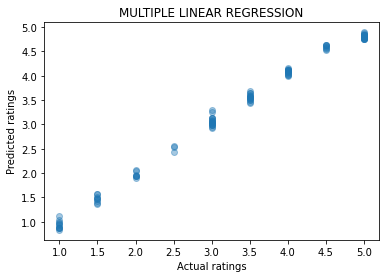

In [161]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("Actual ratings")
plt.ylabel("Predicted ratings")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

기존 SVD, SVD++, NMF의 성능을 확인해보았다.

In [162]:
# RMSE
print("RMSE of SVD:",round(mean_squared_error(X['SVD'], y)**0.5,4))
print("RMSE of SVDpp:",round(mean_squared_error(X['SVDpp'], y)**0.5,4))
print("RMSE of NMF:",round(mean_squared_error(X['NMF'], y)**0.5,4))

RMSE of SVD: 1.1976
RMSE of SVDpp: 1.176
RMSE of NMF: 0.2669


In [110]:
# MSE
from sklearn.metrics import mean_absolute_error
print("MSE of SVD:",round(mean_absolute_error(X['SVD'],y),4))
print("MSE of SVDpp:",round(mean_absolute_error(X['SVDpp'],y),4))
print("MSE of NMF:",round(mean_absolute_error(X['NMF'],y),4))

MSE of SVD: 1.0193
MSE of SVDpp: 0.9999
MSE of NMF: 0.2337


In [111]:
# 평점이 없는 동아리 예측
x_test = test[['SVD','SVDpp','NMF']]
test_pred = mlr.predict(x_test)

df1 = pd.DataFrame(test[['userid','clubid']])
df1.index = list(range(test.shape[0]))
df2 = pd.DataFrame(test_pred, columns=['pred'])

reg_pred = pd.concat([df1,df2],ignore_index=True,axis=1)
reg_pred.columns = ['userid','clubid','pred']
reg_pred # 평점을 매기지 않은 모든 동아리에 대한 예측 평점

cnt = 0
for i in reg_pred['userid'].unique():
  temp = reg_pred.loc[reg_pred['userid']==i,:]
  temp = temp.sort_values(by=['pred'],axis=0,ascending=False)[:10]
  if cnt == 0:
    reg = temp
    cnt += 1
  else :
    reg = pd.concat([reg,temp],axis=0,ignore_index=True)
reg # 전체 유저에 대한 유저별 상위 10개의 예측 평점 동아리 데이터

,userid,clubid,pred
0,abgc4531,뉴런,3.707498
1,abgc4531,불교학생회,3.433192
2,abgc4531,팝콘,3.415430
3,abgc4531,열두루달,3.385828
4,abgc4531,KURC,3.305610
...,...,...,...
595,dongari,KUSA,4.467019
596,dongari,예술비평연구회,4.380654
597,dongari,운화회,4.376750
598,dongari,농구연구회,4.355967


In [112]:
reg.to_csv('/gdrive/Shared drives/datathon_2021/result_regression.csv')

### gbm

In [163]:
from sklearn import ensemble

gbm = ensemble.GradientBoostingRegressor()
gbm.fit(X_train, y_train) 

y_predict_t = gbm.predict(X_train)
y_predict = gbm.predict(X_test)

print('train RMSE = ', round(mean_squared_error(y_predict_t, y_train)**0.5,4)) 
print('test RMSE = ', round(mean_squared_error(y_predict, y_test)**0.5,4)) # 회귀 분석보다 작은 값을 가짐

train RMSE =  0.0003
test RMSE =  0.0684


In [114]:
# 평점이 없는 동아리 예측
test_pred = gbm.predict(x_test)

df1 = pd.DataFrame(test[['userid','clubid']])
df1.index = list(range(test.shape[0]))
df2 = pd.DataFrame(test_pred, columns=['pred'])

gbm_pred = pd.concat([df1,df2],ignore_index=True,axis=1)
gbm_pred.columns = ['userid','clubid','pred']
gbm_pred['pred'] = round(gbm_pred['pred'],2)
gbm_pred # 평점을 매기지 않은 모든 동아리에 대한 예측 평점

cnt = 0
for i in gbm_pred['userid'].unique():
  temp = gbm_pred.loc[gbm_pred['userid']==i,:]
  temp = temp.sort_values(by=['pred'],axis=0,ascending=False)[:10]
  if cnt == 0:
    gbm = temp
    cnt += 1
  else :
    gbm = pd.concat([gbm,temp],axis=0,ignore_index=True)
gbm # 전체 유저에 대한 유저별 상위 10개의 예측 평점 동아리 데이터

,userid,clubid,pred
0,abgc4531,뉴런,3.5
1,abgc4531,열두루달,3.5
2,abgc4531,팝콘,3.5
3,abgc4531,불교학생회,3.5
4,abgc4531,로타랙트,3.0
...,...,...,...
595,dongari,운화회,4.5
596,dongari,로타랙트,4.5
597,dongari,JASS,4.5
598,dongari,수호회,4.5


In [115]:
gbm.to_csv('/gdrive/Shared drives/datathon_2021/result_gbm.csv')

## 결과

### Personalizaton

### mean

In [116]:
copy = recommendation
copy['indicator'] = 1

club_user = recommendation.pivot_table('indicator',index='clubname', columns='userid')
club_user.fillna(0, inplace=True)

similarity = cosine_similarity(club_user)
similarity = pd.DataFrame(data=similarity, index=club_user.index, columns=club_user.index)

upper = np.triu(similarity)
n = similarity.shape[0]
round(1-sum(sum(upper)-1)/(n*(n-1)/2),4) # 1-upper triangle의 평균

0.8515

### regression

In [117]:
copyy = reg
copyy['indicator'] = 1

club_user = reg.pivot_table('indicator',index='clubid', columns='userid')
club_user.fillna(0, inplace=True)

similarity = cosine_similarity(club_user)
similarity = pd.DataFrame(data=similarity, index=club_user.index, columns=club_user.index)

upper = np.triu(similarity)
n = similarity.shape[0]
round(1-sum(sum(upper)-1)/(n*(n-1)/2),4) # 1-upper triangle의 평균

0.8753

### gbm

In [118]:
copyy = gbm
copyy['indicator'] = 1

club_user = gbm.pivot_table('indicator',index='clubid', columns='userid')
club_user.fillna(0, inplace=True)

similarity = cosine_similarity(club_user)
similarity = pd.DataFrame(data=similarity, index=club_user.index, columns=club_user.index)

upper = np.triu(similarity)
n = similarity.shape[0]
round(1-sum(sum(upper)-1)/(n*(n-1)/2),4) # 1-upper triangle의 평균

0.8682

수치평균을 사용한 결과 personalization 값이 작아진 것으로 보아, 유저들 간 추천된 동아리가 서로 비슷한 것을 알 수 있다.

regression에서 personalization 값이 큰 것으로 보아, 유저들 간 추천된 동아리가 서로 다른 것을 알 수 있다.  

즉, regression, gbm, 수치평균 순으로 추천시스템이 각 유저에게 개인화된 경험을 제공한 것으로 해석할 수 있다.



## Intra Similarity

### mean

In [119]:
copy2 = contents
copy2.index = copy2['동아리']
copy2 = copy2.iloc[:,1:]

In [120]:
# intra similarity 계산하는 함수
def intra_similarity(userid, type):
  global recommendation, reg, gbm
  if type == "mean" :
    intralist = recommendation.loc[recommendation['userid']==userid,'clubname']
  elif type == "reg" :
    intralist  = reg.loc[reg['userid']==userid,'clubid']
  elif type == "gbm" :
    intralist = gbm.loc[gbm['userid']==userid,'clubid']

  intra = copy2.loc[intralist,:]
  intra = cosine_similarity(intra)
  n = intra.shape[0]
  upper = np.triu(intra)
  result = sum(sum(upper)-1)/(n*(n-1)/2)
  return result

In [121]:
# 전체 평균
result = []
for user in recommendation['userid'].unique():
  result.append(float(intra_similarity(user,type="mean")))

round(sum(result)/len(recommendation['userid'].unique()),4)

0.3726


### regression

In [122]:
# 전체 평균
result = []
for user in reg_pred['userid'].unique():
  result.append(float(intra_similarity(user,type="reg")))

round(sum(result)/len(reg_pred['userid'].unique()),4)

0.3709

###gbm

In [123]:
# 전체 평균
result = []
for user in reg_pred['userid'].unique():
  result.append(float(intra_similarity(user,type="gbm")))

round(sum(result)/len(reg_pred['userid'].unique()),4)

0.3739

수치 평균에서 큰 값을 가지는 것으로부터 비교적으로 각 유저가 비슷한 키워드를 가지는 동아리를 추천받고 있음을 알 수 있다.

gbm에서 상대적으로 작은 값을 가지는 것으로부터 비교적 각 유저는 다른 키워드를 가지는 동아리를 추천받고 있음을 알 수 있다.  




